In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2020-01-06 11:07:55.297720
thunder  Mon Jan  6 11:07:55 2020
[0] GeForce GTX 1080 Ti | 50'C, 100 % | 10936 / 11178 MB | david(10926M)
[1] GeForce GTX 1080 Ti | 58'C,  98 % | 10936 / 11178 MB | david(10926M)
[2] GeForce GTX 1080 Ti | 62'C,  93 % | 10936 / 11178 MB | david(10926M)
[3] GeForce GTX 1080 Ti | 64'C, 100 % | 10936 / 11178 MB | david(10926M)
[4] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 28'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[6] GeForce GTX 1080 Ti | 53'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[7] GeForce GTX 1080 Ti | 50'C,   0 % | 10895 / 11178 MB | anthoula(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Mon Jan  6 11:08:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 37%   50C    P2    81W / 250W |  10936MiB / 11178MiB |     82%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 43%   54C    P2    70W / 250W |  10936Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "4"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


In [16]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [17]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [18]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [19]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [20]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [21]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [22]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [23]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [24]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [25]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [26]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [27]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [28]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

Normalizing using ImageDataGenerator https://stackoverflow.com/questions/41855512/how-does-data-normalization-work-in-keras-during-prediction

In [29]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [30]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [31]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [32]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [33]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 39s 785ms/step - loss: 0.7159 - Accuracy: 0.5875 - Precision: 0.5890 - Recall: 0.5905 - F1: 0.5831 - AUC: 0.5985 - val_loss: 3.6273 - val_Accuracy: 0.0312 - val_Precision: 0.0312 - val_Recall: 0.6000 - val_F1: 0.0589 - val_AUC: 0.3616
Epoch 2/200
50/50 [==============================] - 28s 570ms/step - loss: 0.6639 - Accuracy: 0.6175 - Precision: 0.5919 - Recall: 0.5883 - F1: 0.5811 - AUC: 0.6662 - val_loss: 1.4102 - val_Accuracy: 0.0281 - val_Precision: 0.0251 - val_Recall: 0.6000 - val_F1: 0.0476 - val_AUC: 0.6234
Epoch 3/200
50/50 [==============================] - 31s 621ms/step - loss: 0.6476 - Accuracy: 0.6388 - Precision: 0.6484 - Recall: 0.6464 - F1: 0.6403 - AUC: 0.6890 - val_loss: 2.9820 - val_Accuracy: 0.0188 - val_Precision: 0.0188 - val_Recall: 0.6000 - val_F1: 0.0364 - val_AUC: 0.6876
Epoch 4/200
50/50 [==============================] - 34s 680ms/step - loss: 0.6403 - Accuracy: 0.6444 - Precision: 0.6489 - Recall: 0.6943 - F1: 0.6

50/50 [==============================] - 19s 372ms/step - loss: 0.5348 - Accuracy: 0.7344 - Precision: 0.7378 - Recall: 0.7629 - F1: 0.7434 - AUC: 0.8091 - val_loss: 0.9716 - val_Accuracy: 0.2594 - val_Precision: 0.0386 - val_Recall: 0.6750 - val_F1: 0.0710 - val_AUC: 0.5715
Epoch 58/200
50/50 [==============================] - 17s 340ms/step - loss: 0.5505 - Accuracy: 0.7181 - Precision: 0.7185 - Recall: 0.7408 - F1: 0.7215 - AUC: 0.7921 - val_loss: 0.9154 - val_Accuracy: 0.2094 - val_Precision: 0.0354 - val_Recall: 0.5667 - val_F1: 0.0658 - val_AUC: 0.6503
Epoch 59/200
50/50 [==============================] - 17s 331ms/step - loss: 0.5153 - Accuracy: 0.7400 - Precision: 0.7126 - Recall: 0.7755 - F1: 0.7353 - AUC: 0.8264 - val_loss: 0.8210 - val_Accuracy: 0.1969 - val_Precision: 0.0295 - val_Recall: 0.6000 - val_F1: 0.0559 - val_AUC: 0.5529
Epoch 60/200
50/50 [==============================] - 16s 328ms/step - loss: 0.5106 - Accuracy: 0.7625 - Precision: 0.7450 - Recall: 0.7880 - F1: 

50/50 [==============================] - 17s 345ms/step - loss: 0.5437 - Accuracy: 0.7219 - Precision: 0.7318 - Recall: 0.7344 - F1: 0.7282 - AUC: 0.7981 - val_loss: 1.0313 - val_Accuracy: 0.1875 - val_Precision: 0.0271 - val_Recall: 0.6000 - val_F1: 0.0517 - val_AUC: 0.5495
Epoch 114/200
50/50 [==============================] - 16s 327ms/step - loss: 0.5114 - Accuracy: 0.7575 - Precision: 0.7485 - Recall: 0.7823 - F1: 0.7589 - AUC: 0.8327 - val_loss: 1.0329 - val_Accuracy: 0.2313 - val_Precision: 0.0575 - val_Recall: 0.7000 - val_F1: 0.1042 - val_AUC: 0.6205
Epoch 115/200
50/50 [==============================] - 16s 330ms/step - loss: 0.5337 - Accuracy: 0.7294 - Precision: 0.7134 - Recall: 0.7662 - F1: 0.7269 - AUC: 0.8108 - val_loss: 1.0381 - val_Accuracy: 0.1750 - val_Precision: 0.0339 - val_Recall: 0.6000 - val_F1: 0.0638 - val_AUC: 0.5495
Epoch 116/200
50/50 [==============================] - 16s 330ms/step - loss: 0.5196 - Accuracy: 0.7525 - Precision: 0.7537 - Recall: 0.7665 - F

50/50 [==============================] - 20s 402ms/step - loss: 0.5232 - Accuracy: 0.7387 - Precision: 0.7122 - Recall: 0.7874 - F1: 0.7383 - AUC: 0.8206 - val_loss: 1.1181 - val_Accuracy: 0.1406 - val_Precision: 0.0145 - val_Recall: 0.4000 - val_F1: 0.0279 - val_AUC: 0.8145
Epoch 170/200
50/50 [==============================] - 18s 357ms/step - loss: 0.5332 - Accuracy: 0.7244 - Precision: 0.7270 - Recall: 0.7501 - F1: 0.7320 - AUC: 0.8087 - val_loss: 1.0922 - val_Accuracy: 0.1531 - val_Precision: 0.0187 - val_Recall: 0.5000 - val_F1: 0.0361 - val_AUC: 0.4057
Epoch 171/200
50/50 [==============================] - 17s 348ms/step - loss: 0.4945 - Accuracy: 0.7619 - Precision: 0.7486 - Recall: 0.7946 - F1: 0.7637 - AUC: 0.8482 - val_loss: 1.0651 - val_Accuracy: 0.1531 - val_Precision: 0.0347 - val_Recall: 0.7000 - val_F1: 0.0654 - val_AUC: 0.5063
Epoch 172/200
50/50 [==============================] - 17s 345ms/step - loss: 0.5159 - Accuracy: 0.7613 - Precision: 0.7671 - Recall: 0.7715 - F

In [34]:
print("Time taken:",end-start)

Time taken: 3838.1591057777405


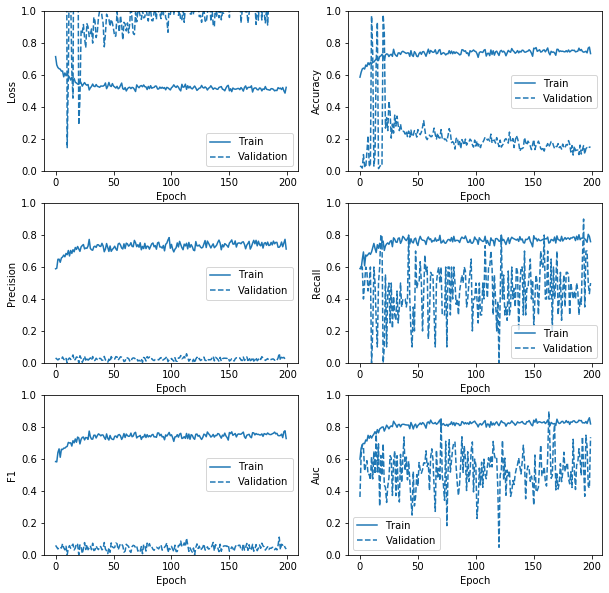

In [35]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [36]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:0.5,1:3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 416ms/step - loss: 0.3930 - Accuracy: 0.5700 - Precision: 0.1003 - Recall: 0.7783 - F1: 0.1738 - AUC: 0.8650 - val_loss: 1.0500 - val_Accuracy: 0.1406 - val_Precision: 0.0246 - val_Recall: 0.4500 - val_F1: 0.0464 - val_AUC: 0.4395
Epoch 2/200
50/50 [==============================] - 19s 386ms/step - loss: 0.3819 - Accuracy: 0.5839 - Precision: 0.0937 - Recall: 0.7967 - F1: 0.1629 - AUC: 0.8539 - val_loss: 1.1247 - val_Accuracy: 0.1281 - val_Precision: 0.0387 - val_Recall: 0.5000 - val_F1: 0.0709 - val_AUC: 0.5479
Epoch 3/200
50/50 [==============================] - 21s 411ms/step - loss: 0.3755 - Accuracy: 0.6069 - Precision: 0.1013 - Recall: 0.6700 - F1: 0.1705 - AUC: 0.8550 - val_loss: 1.0936 - val_Accuracy: 0.1219 - val_Precision: 0.0412 - val_Recall: 0.7667 - val_F1: 0.0775 - val_AUC: 0.4866
Epoch 4/200
50/50 [==============================] - 20s 404ms/step - loss: 0.3718 - Accuracy: 0.6125 - Precision: 0.0660 - Recall: 0.50

50/50 [==============================] - 14s 272ms/step - loss: 0.2655 - Accuracy: 0.9044 - Precision: 0.2687 - Recall: 0.4313 - F1: 0.3100 - AUC: 0.8564 - val_loss: 0.7008 - val_Accuracy: 0.5219 - val_Precision: 0.0318 - val_Recall: 0.4000 - val_F1: 0.0584 - val_AUC: 0.6520
Epoch 58/200
50/50 [==============================] - 14s 278ms/step - loss: 0.2425 - Accuracy: 0.9144 - Precision: 0.2370 - Recall: 0.3517 - F1: 0.2658 - AUC: 0.8351 - val_loss: 0.6763 - val_Accuracy: 0.6094 - val_Precision: 0.0312 - val_Recall: 0.4000 - val_F1: 0.0578 - val_AUC: 0.7292
Epoch 59/200
50/50 [==============================] - 14s 278ms/step - loss: 0.2558 - Accuracy: 0.9144 - Precision: 0.2993 - Recall: 0.3533 - F1: 0.2899 - AUC: 0.8673 - val_loss: 0.8136 - val_Accuracy: 0.5781 - val_Precision: 0.0426 - val_Recall: 0.4000 - val_F1: 0.0763 - val_AUC: 0.7499
Epoch 60/200
50/50 [==============================] - 14s 282ms/step - loss: 0.2769 - Accuracy: 0.9044 - Precision: 0.2197 - Recall: 0.2549 - F1: 

50/50 [==============================] - 15s 299ms/step - loss: 0.2395 - Accuracy: 0.9300 - Precision: 0.3063 - Recall: 0.3367 - F1: 0.2961 - AUC: 0.8761 - val_loss: 0.5631 - val_Accuracy: 0.7719 - val_Precision: 0.0350 - val_Recall: 0.1333 - val_F1: 0.0468 - val_AUC: 0.6136
Epoch 114/200
50/50 [==============================] - 14s 274ms/step - loss: 0.2893 - Accuracy: 0.9144 - Precision: 0.2533 - Recall: 0.3093 - F1: 0.2405 - AUC: 0.8306 - val_loss: 0.5614 - val_Accuracy: 0.8281 - val_Precision: 0.0125 - val_Recall: 0.1000 - val_F1: 0.0222 - val_AUC: 0.3142
Epoch 115/200
50/50 [==============================] - 14s 283ms/step - loss: 0.2585 - Accuracy: 0.9244 - Precision: 0.2383 - Recall: 0.3133 - F1: 0.2454 - AUC: 0.8263 - val_loss: 0.5401 - val_Accuracy: 0.7969 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2264
Epoch 116/200
50/50 [==============================] - 15s 292ms/step - loss: 0.2681 - Accuracy: 0.9275 - Precision: 0.2500 - Recall

50/50 [==============================] - 14s 283ms/step - loss: 0.2420 - Accuracy: 0.9212 - Precision: 0.1950 - Recall: 0.2333 - F1: 0.1851 - AUC: 0.8240 - val_loss: 0.5269 - val_Accuracy: 0.7625 - val_Precision: 0.0872 - val_Recall: 0.4417 - val_F1: 0.1374 - val_AUC: 0.7553
Epoch 142/200
50/50 [==============================] - 14s 279ms/step - loss: 0.2894 - Accuracy: 0.9150 - Precision: 0.2790 - Recall: 0.2824 - F1: 0.2471 - AUC: 0.8201 - val_loss: 0.6278 - val_Accuracy: 0.7406 - val_Precision: 0.0379 - val_Recall: 0.2500 - val_F1: 0.0650 - val_AUC: 0.6317
Epoch 143/200
50/50 [==============================] - 15s 308ms/step - loss: 0.2394 - Accuracy: 0.9281 - Precision: 0.2797 - Recall: 0.2847 - F1: 0.2613 - AUC: 0.8703 - val_loss: 0.5429 - val_Accuracy: 0.6750 - val_Precision: 0.0234 - val_Recall: 0.0833 - val_F1: 0.0354 - val_AUC: 0.4329
Epoch 144/200
50/50 [==============================] - 15s 298ms/step - loss: 0.2631 - Accuracy: 0.9156 - Precision: 0.1517 - Recall: 0.1590 - F

50/50 [==============================] - 18s 364ms/step - loss: 0.2516 - Accuracy: 0.9356 - Precision: 0.2283 - Recall: 0.2300 - F1: 0.2033 - AUC: 0.8303 - val_loss: 0.5279 - val_Accuracy: 0.7844 - val_Precision: 0.0077 - val_Recall: 0.1000 - val_F1: 0.0143 - val_AUC: 0.4715
Epoch 198/200
50/50 [==============================] - 18s 355ms/step - loss: 0.2552 - Accuracy: 0.9300 - Precision: 0.2717 - Recall: 0.2207 - F1: 0.2184 - AUC: 0.8295 - val_loss: 0.5479 - val_Accuracy: 0.8094 - val_Precision: 0.0536 - val_Recall: 0.3000 - val_F1: 0.0900 - val_AUC: 0.7159
Epoch 199/200
50/50 [==============================] - 17s 335ms/step - loss: 0.2414 - Accuracy: 0.9344 - Precision: 0.2117 - Recall: 0.2533 - F1: 0.2206 - AUC: 0.8379 - val_loss: 0.5628 - val_Accuracy: 0.7719 - val_Precision: 0.0111 - val_Recall: 0.0333 - val_F1: 0.0167 - val_AUC: 0.4977
Epoch 200/200
50/50 [==============================] - 16s 311ms/step - loss: 0.2505 - Accuracy: 0.9306 - Precision: 0.2990 - Recall: 0.2523 - F

In [37]:
print("Time taken:",end-start)

Time taken: 3120.48392534256


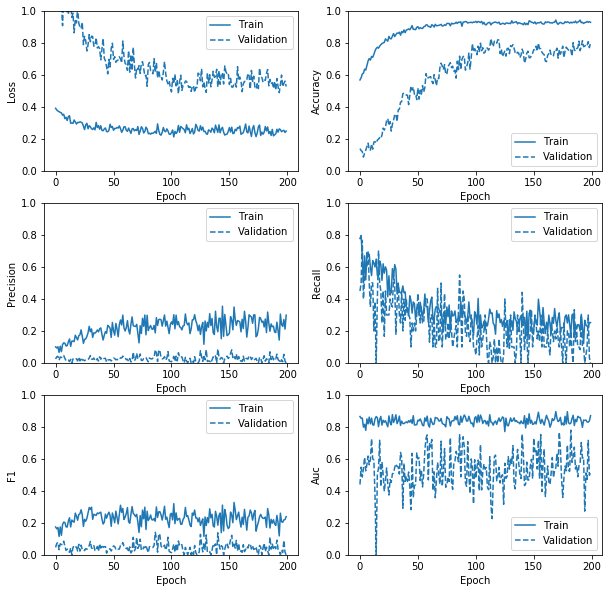

In [38]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [ ]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [ ]:
# print("Time taken:",end-start)

In [ ]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [ ]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.2,5],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [ ]:
# print("Time taken:",end-start)

In [ ]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [39]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 18s 177ms/step


In [40]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.745 :   0.490
Accuracy : 0.427 :   0.787
Precision : 0.022 :   0.021
Recall : 0.355 :   0.094
F1 : 0.042 :   0.032
AUC : 0.577 :   0.468


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [41]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(839.0680725574493, 132.81712770462036)

In [52]:
np.save(funduspath_CR + str(n_epochs) + 'ep_model_7_pred_tr.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_model_7_pred_val.npy', pred_vl)

In [ ]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [43]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

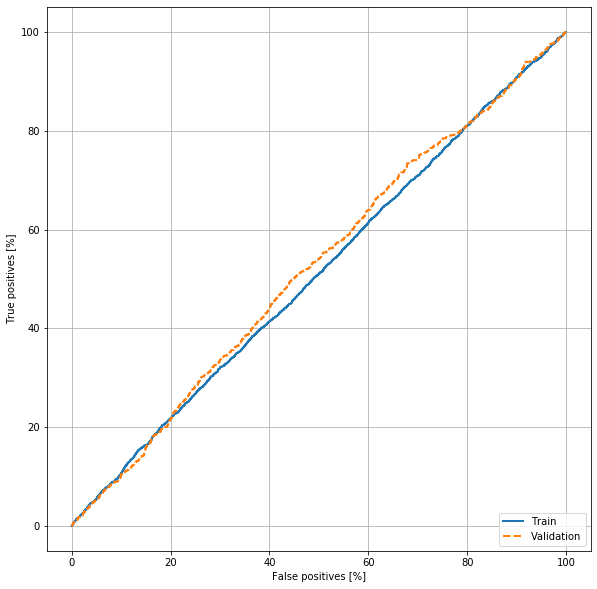

In [44]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 44080 
FP: 55375 
FN: 1029 
TP: 1350
Healthy Patients - correctly identified (True Negatives):  44080 0.4432155246091197
Healthy Patients - predicted to have glaucoma (False Positives):  55375 0.5567844753908803
Glaucoma Patients - predicted healthy (False Negatives):  1029 0.43253467843631777
Glaucoma Patients - correctly identified (True Positives):  1350 0.5674653215636822

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


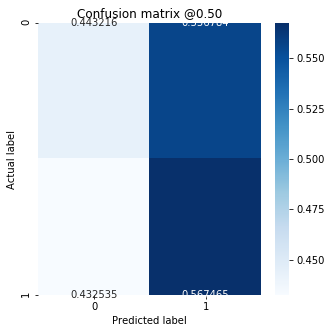

In [45]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 26582 
FP: 6552 
FN: 636 
TP: 173
Healthy Patients - correctly identified (True Negatives):  26582 0.8022574998490976
Healthy Patients - predicted to have glaucoma (False Positives):  6552 0.1977425001509024
Glaucoma Patients - predicted healthy (False Negatives):  636 0.7861557478368356
Glaucoma Patients - correctly identified (True Positives):  173 0.2138442521631644

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


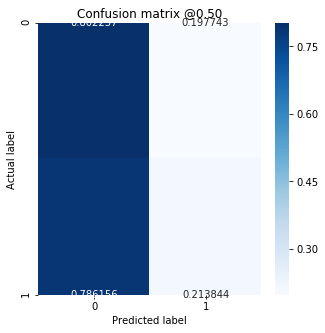

In [46]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [49]:
# get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- train_twice-Copy6-edited-MODEL7-Copy1.ipynb'

In [50]:
# history = up3_history
# tag_value = "same as copy 5 with feature wise centre = True"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/ds/environments/python2020/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 193, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/ds/environments/python2020/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 247, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/ds/environments/python2020/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 159, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/ds/notebooks/patra/mlruns/mlruns/meta.yaml' does not exist.
Traceback (most recent call last):
  File "/ds/environments/python2020/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 193, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/ds/environments/python2020/lib/pyth

In [51]:
# client = MlflowClient()
# run = client.create_run('27')
# client.set_tag(run.info.run_id, "tag_key", tag_value)